In [1]:
# Install dependencies
!pip install praw networkx matplotlib python-louvain tqdm --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.3/189.3 kB 3.8 MB/s eta 0:00:00


In [2]:
import praw
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
import community as community_louvain


In [3]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import logging
logging.getLogger("praw").setLevel(logging.ERROR)

# Set up Reddit API
reddit = praw.Reddit(
    client_id="15tJrUm_rfV5qEFQYXSpEA",
    client_secret="6YCJ_AfVqrooyJoU65k2oeeeTUxYVg",
    user_agent="GDM_Project by u/Hemant_miranka"
)


In [4]:
# --- Parameters ---
subreddit_name = "AskReddit"
num_posts = 20               # Fewer posts
max_interactions = 300       # Smaller graph
min_comments_required = 50   # Only posts with more discussion

edges = []
print(f"Fetching top threads from r/{subreddit_name}...")

# Collect Interactions
subreddit = reddit.subreddit(subreddit_name)
for submission in tqdm(subreddit.top(limit=num_posts)):
    if submission.num_comments < min_comments_required:
        continue

    submission.comments.replace_more(limit=5)  # Get longer threads
    for comment in submission.comments.list():
        if len(edges) >= max_interactions:
            break
        author = str(comment.author)
        if comment.parent_id.startswith("t1_"):
            try:
                parent = comment.parent()
                parent_author = str(parent.author)
                if author != "None" and parent_author != "None" and author != parent_author:
                    edges.append((author, parent_author))
            except:
                continue

print(f"\nCollected {len(edges)} interactions.")

Fetching top threads from r/AskReddit...


20it [02:15,  6.75s/it]


Collected 300 interactions.


In [5]:
# --- Save raw data before graph ---
df_raw = pd.DataFrame(edges, columns=["replier", "parent"])
df_raw.to_csv("raw_interactions.csv", index=False)
print("Saved raw interactions to raw_interactions.csv")

Saved raw interactions to raw_interactions.csv


In [6]:
# --- Build Directed Graph ---
G_directed = nx.DiGraph()
for a, b in edges:
    if G_directed.has_edge(a, b):
        G_directed[a][b]["weight"] += 1
    else:
        G_directed.add_edge(a, b, weight=1)

print(f"Directed graph: {G_directed.number_of_nodes()} nodes, {G_directed.number_of_edges()} edges.")

Directed graph: 293 nodes, 293 edges.


In [7]:
# --- Convert to Undirected Graph with Preserved Weights ---
G = nx.Graph()
for u, v, data in G_directed.edges(data=True):
    if G.has_edge(u, v):
        G[u][v]['weight'] += data['weight']
    else:
        G.add_edge(u, v, weight=data['weight'])

print(f"Undirected graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges.")

Undirected graph: 293 nodes, 269 edges.


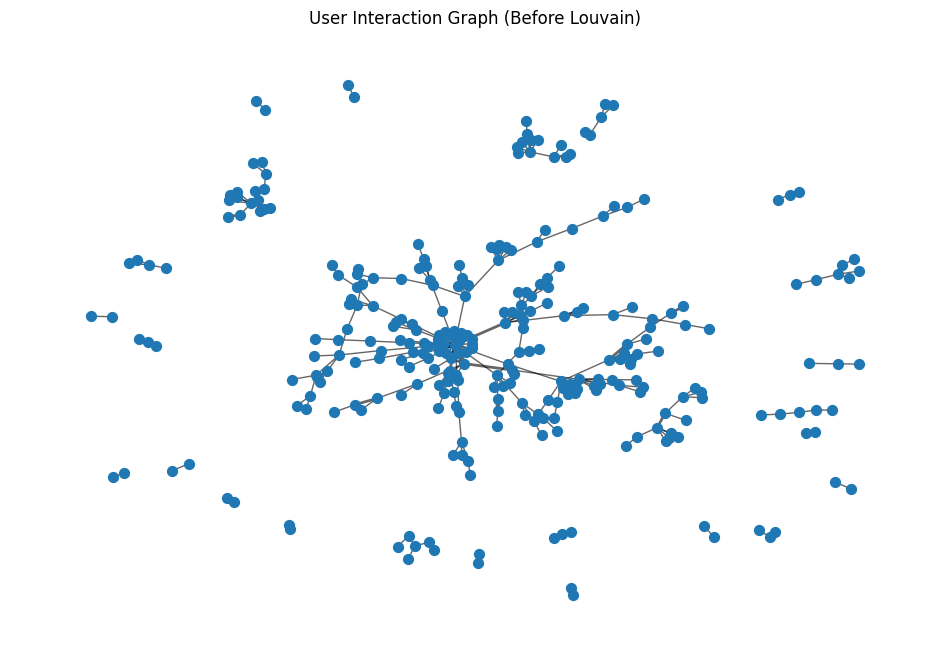

In [8]:
# --- Visualize the Graph Before Louvain ---
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)
weights = [G[u][v]['weight'] for u, v in G.edges()]
nx.draw_networkx_nodes(G, pos, node_size=50)
nx.draw_networkx_edges(G, pos, width=weights, alpha=0.6)
plt.title("User Interaction Graph (Before Louvain)")
plt.axis('off')
plt.show()

In [9]:
# --- Louvain Community Detection ---
partition = community_louvain.best_partition(G)
nx.set_node_attributes(G, partition, "community")

# --- Save Community Info ---
df_communities = pd.DataFrame(list(partition.items()), columns=["user", "community"])
df_communities.to_csv("reddit_communities.csv", index=False)
nx.write_gexf(G, "reddit_graph_weighted.gexf")
print("Saved community assignments to reddit_communities.csv and graph to reddit_graph_weighted.gexf")

Saved community assignments to reddit_communities.csv and graph to reddit_graph_weighted.gexf


In [10]:
# Install required libraries (only needed once)
!pip install networkx matplotlib pyvis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 44.6 MB/s eta 0:00:00


In [11]:
# Import libraries
import networkx as nx
import matplotlib.pyplot as plt
from pyvis.network import Network

In [13]:
# Load graph
G = nx.read_gexf("reddit_graph_weighted.gexf")


G = G.to_undirected()

In [14]:
# --- 1. Extract existing community info ---
communities = nx.get_node_attributes(G, "community")
num_communities = len(set(communities.values()))
print(f"Number of communities: {num_communities}")

Number of communities: 40


In [15]:
# --- 2. Degree statistics ---
degrees = dict(G.degree())
avg_degree = sum(degrees.values()) / len(degrees)
max_degree_user = max(degrees, key=degrees.get)
print(f"Average degree: {avg_degree:.2f}")
print(f"Highest degree: {degrees[max_degree_user]} (User: {max_degree_user})")

Average degree: 1.84
Highest degree: 34 (User: ShoddySubstance)


<ipython-input-16-f808d939dfe0>:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab20", num_communities)


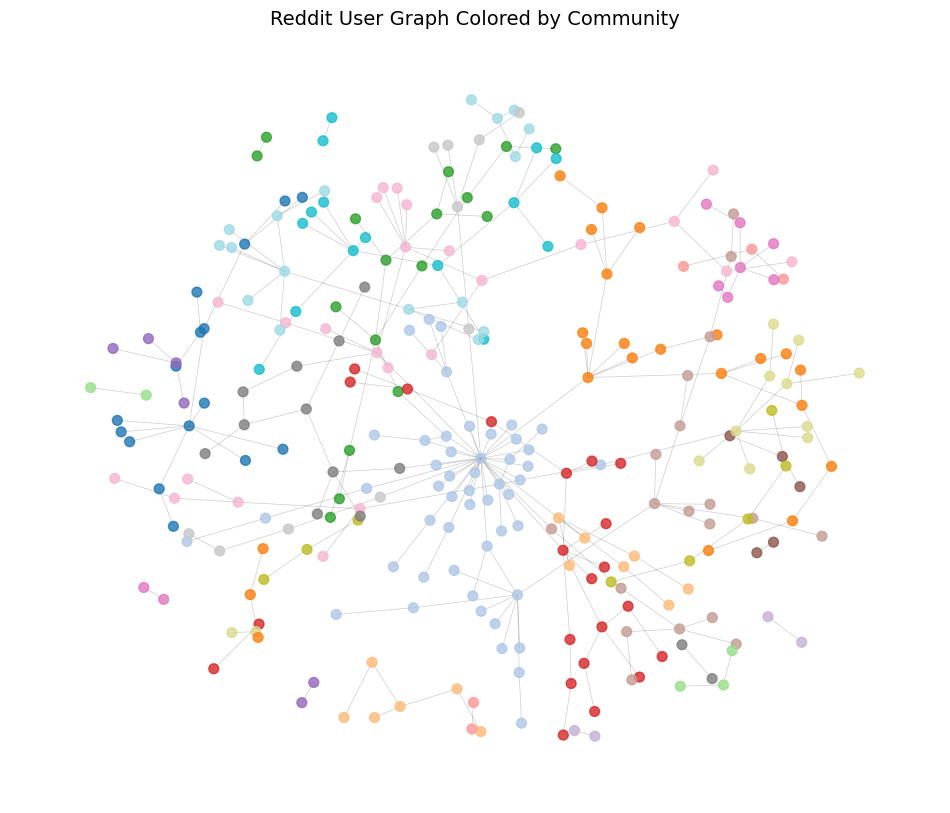

In [16]:
# --- 3. Visualization with matplotlib ---
plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G, seed=42, k=0.15)

# Assign a color per community (tab20 colormap)
import matplotlib.cm as cm
import numpy as np
community_colors = [communities[node] for node in G.nodes()]
cmap = cm.get_cmap("tab20", num_communities)
node_colors = [cmap(community_colors[i]) for i in range(len(community_colors))]

nx.draw_networkx_nodes(G, pos, node_size=50, node_color=node_colors, alpha=0.8)
nx.draw_networkx_edges(G, pos, alpha=0.2, width=0.5)

plt.title("Reddit User Graph Colored by Community", fontsize=14)
plt.axis("off")
plt.show()


In [19]:
import networkx as nx
from pyvis.network import Network
from IPython.display import IFrame

# Load graph from GEXF file
G = nx.read_gexf("reddit_graph_weighted.gexf")

# Extract community assignments
communities = nx.get_node_attributes(G, "community")

# Create PyVis network (cdn_resources fixed here)
pyvis_net = Network(notebook=True,
                    width="1000px",
                    height="700px",
                    bgcolor="#222222",
                    font_color="white",
                    cdn_resources='in_line')  # FIXED: Only here

pyvis_net.barnes_hut()

# Add nodes with labels and community info
for node in G.nodes():
    pyvis_net.add_node(node,
                       label=node,
                       title=f"User: {node}<br>Community: {communities.get(node)}<br>Degree: {G.degree(node)}",
                       group=communities.get(node))

# Add edges with weight
for source, target, data in G.edges(data=True):
    pyvis_net.add_edge(source, target, value=data.get("weight", 1))

# Add physics configuration button
pyvis_net.show_buttons(filter_=['physics'])

# Save and display
html_path = "reddit_community_graph_interactive.html"
pyvis_net.show(html_path)

# Display inline in Colab
IFrame(html_path, width=1000, height=750)


reddit_community_graph_interactive.html


#Some Notes
1. An interaction is counted when:

A user replies to another user's comment.
The edge represents a reply relationship from the replier (author) to the user they replied to (parent_author).
So, each interaction is one reply between two unique users.

2. Constructing smaller and deser graphs with lower threds and max interaction, deth increase with replace_limit

3. Getting the top posts now with .top instead of Hot

4. Getting sample dataset in the form of CSV

5. When you convert from a directed graph to an undirected graph:

There may be both edges: u → v and v → u in the original G_directed.
In the undirected graph, they become a single edge u — v.
So, to preserve information, you must add their weights.

If:
G_directed has A → B (weight=3)
and B → A (weight=2)
Then the final undirected edge A — B will have:

G['A']['B']['weight'] == 5

6. Calculating the degrees also max degree is 34 and avg degree is 1.84